# Sentiment Timeseries

In [220]:
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [221]:
df = pd.read_csv(pathlib.Path("../data/news_select_companies_with_sent.csv"))
sentiment_df = df[["ticker", "release_date", "dic_sentiment_dis"]]

Make a dictionary with tickers as keys and DataFrames with date and sentiment as values.

In [222]:
ticker_dict = {}
for index, row in sentiment_df.iterrows():

    ticker = row["ticker"]
    date = row["release_date"]
    sentiment = row["dic_sentiment_dis"]

    if ticker not in ticker_dict:
        ticker_dict[ticker] = pd.DataFrame(columns=["date", "sentiment"])

    new_row = pd.DataFrame({"date": [dt.strptime(str(date), "%Y-%m-%d").date()], "sentiment": [sentiment]})
    ticker_dict[ticker] = pd.concat([ticker_dict[ticker], new_row], ignore_index=True)


Take the monthly average of the sentiment.

In [ ]:
def monthly_average(ticker_df):
    """
    Take the monthly average of the sentiment values.

    ticker_df: pd.DataFrame with dates (dt.datetime) and sentiments values.

    Returns a list of the new dates where the days are set to 1 and a list
    of the monthly average sentiment values.
    """
    ticker_df = ticker_df.sort_values(by="date")
    average_sentiments = []

    first_date = ticker_df["date"].iloc[0]
    current_month = first_date.month
    months = [dt(first_date.year, first_date.month, 1).date()]
    sentiments = [ticker_df["sentiment"].iloc[0]]

    for _, row in ticker_df.iterrows():
        sentiments.append(row["sentiment"])
        date = row["date"]

        if date.month != current_month:
            months.append(dt(date.year, date.month, 1).date())
            average_sentiments.append(np.mean(sentiments))
            current_month = date.month

    average_sentiments.append(np.mean(sentiments))

    return months, average_sentiments


Divide tickers in (random) groups of 5 for plotting, so plot is not too crowded.

In [ ]:
tickers = []
five_tickers = []

for i, ticker in enumerate(ticker_dict):
    i+=1
    five_tickers.append(ticker)
    if i % 5 == 0:
        tickers.append(five_tickers)
        five_tickers = []

print(tickers)


[['MSFT', 'TSLA', 'V', 'BAC', 'XOM'], ['KO', 'AAPL', 'PG', 'AMZN', 'HD'], ['LLY', 'WMT', 'UNH', 'MA', 'CVX'], ['JNJ', 'NVDA', 'MRK', 'JPM', 'PFE']]


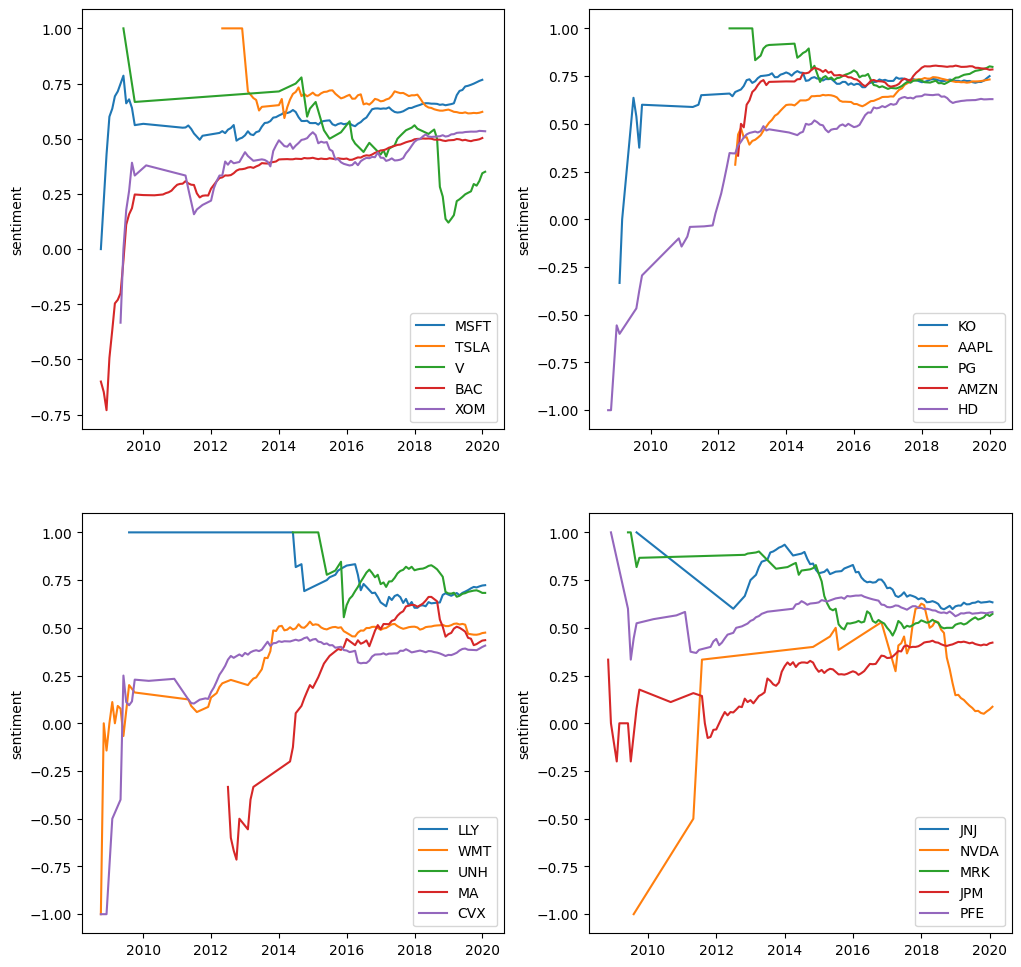

In [ ]:
plt.figure(figsize= (12, 12))
for i, five_tickers in enumerate(tickers):
    i+=1
    plt.subplot(2, 2, i)

    for ticker in five_tickers:
        dates, sentiment = monthly_average(ticker_dict[ticker])
        plt.plot(dates, sentiment, label = ticker)
    plt.ylabel("sentiment")
    plt.legend()

plt.show()

In the above graphs we can observe that for most stocks there is not enough news article data before around 2014

In [ ]:
def cut_data(dates, sentiments, start_date):
    """
    Remove all the data before the start date. If the start date
    is not in dates, find a next start_date that is in dates.
    """
    while start_date not in dates:
        start_date += relativedelta(months=+1)
    index = dates.index(start_date)
    return dates[index:], sentiments[index:]

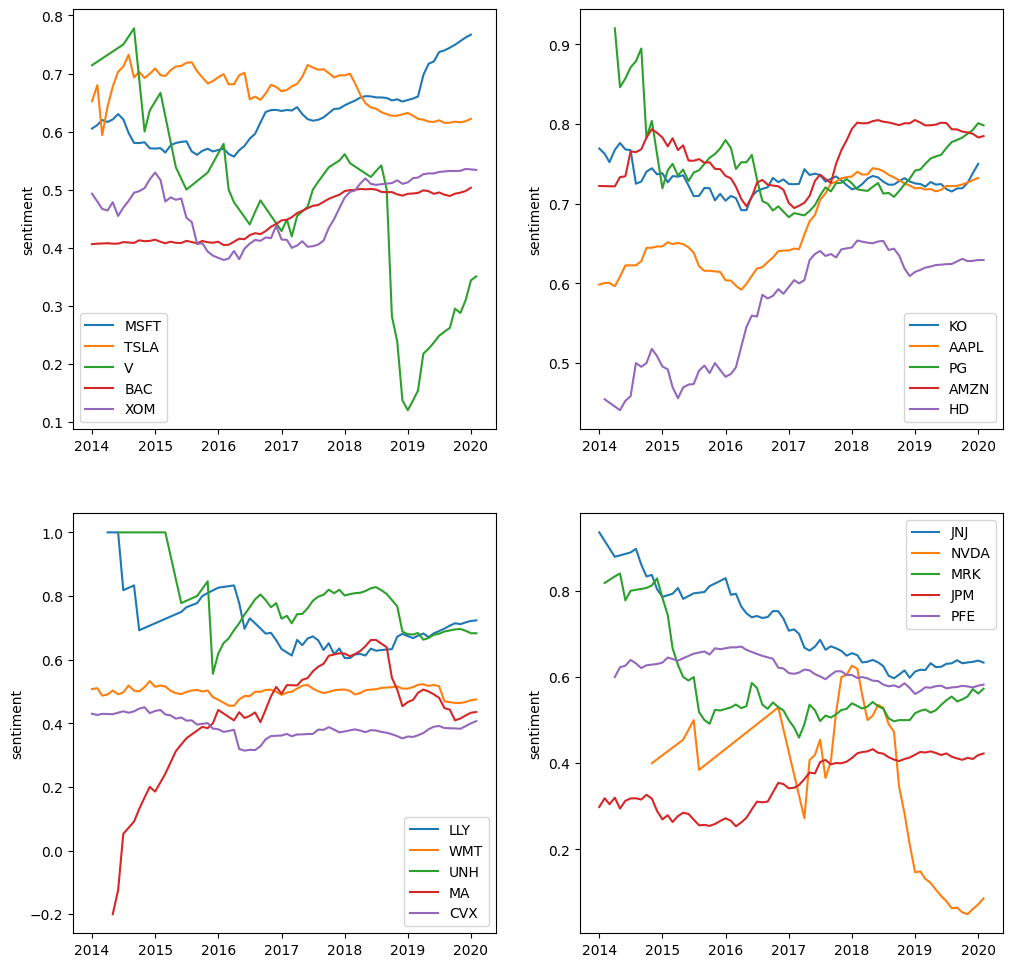

In [ ]:
plt.figure(figsize= (12, 12))
for i, five_tickers in enumerate(tickers):
    i+=1
    plt.subplot(2, 2, i)

    for ticker in five_tickers:
        dates, sentiment = monthly_average(ticker_dict[ticker])

        # Remove all data from before 2014 and save in the ticker_dict
        cut_dates, cut_sentiment = cut_data(dates, sentiment, dt(2014, 1, 1).date())
        ticker_dict[ticker] = list(zip(cut_dates, cut_sentiment))

        plt.plot(cut_dates, cut_sentiment, label = ticker)

    plt.ylabel("sentiment")
    plt.legend()

plt.show()

In [ ]:
print((ticker_dict["MSFT"]))

[(datetime.date(2014, 1, 1), 0.6051948051948052), (datetime.date(2014, 2, 1), 0.6112531969309463), (datetime.date(2014, 3, 1), 0.62), (datetime.date(2014, 4, 1), 0.616504854368932), (datetime.date(2014, 5, 1), 0.6208530805687204), (datetime.date(2014, 6, 1), 0.6301369863013698), (datetime.date(2014, 7, 1), 0.6211453744493393), (datetime.date(2014, 8, 1), 0.597457627118644), (datetime.date(2014, 9, 1), 0.5804480651731161), (datetime.date(2014, 10, 1), 0.5801980198019802), (datetime.date(2014, 11, 1), 0.581573896353167), (datetime.date(2014, 12, 1), 0.5711645101663586), (datetime.date(2015, 1, 1), 0.5706806282722513), (datetime.date(2015, 2, 1), 0.5714285714285714), (datetime.date(2015, 3, 1), 0.5638629283489096), (datetime.date(2015, 4, 1), 0.576437587657784), (datetime.date(2015, 5, 1), 0.5803452855245684), (datetime.date(2015, 6, 1), 0.5821656050955414), (datetime.date(2015, 7, 1), 0.5832335329341317), (datetime.date(2015, 8, 1), 0.5656213704994193), (datetime.date(2015, 9, 1), 0.5599